# Imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from imutils import paths
from google.colab import drive

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import cv2

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
# Mounting Google Drive to access the dataset
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Change the current working directory to the folder containing the dataset

%cd /gdrive/MyDrive/Datasets/Alcohol Dataset

/gdrive/MyDrive/Datasets/Alcohol Dataset


In [ ]:
# Counting the number of images in each category of the dataset

al_train = !find '/gdrive/MyDrive/Datasets/Alcohol Dataset/train/alcoholic' -type f | wc -l
al_train = int(int(al_train[0]))

non_train = !find '/gdrive/MyDrive/Datasets/Alcohol Dataset/train/nonalcoholic' -type f | wc -l
non_train = int(int(non_train[0]))

al_valid = !find '/gdrive/MyDrive/Datasets/Alcohol Dataset/valid/alcoholic' -type f | wc -l
al_valid = int(int(al_valid[0]))

non_vaid = !find '/gdrive/MyDrive/Datasets/Alcohol Dataset/valid/nonalcoholic' -type f | wc -l
non_vaid = int(int(non_vaid[0]))

al_test = !find '/gdrive/MyDrive/Datasets/Alcohol Dataset/test/alcoholic' -type f | wc -l
al_test = int(int(al_test[0]))

non_test = !find '/gdrive/MyDrive/Datasets/Alcohol Dataset/test/nonalcoholic' -type f | wc -l
non_test = int(int(non_test[0]))

# Print the number of images in each category

print(al_train)
print(non_train)

print(al_valid)
print(non_vaid)

print(al_test)
print(non_test)

2500
2500
1000
1000
450
450


# Mobile Net

In [ ]:
# Load the MobileNet model pre-trained on the ImageNet dataset

mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
# Define a function to prepare an image for input to the model
def prepare_image(file):
    img_path = '/gdrive/MyDrive/Kaggle/data/sample/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

## Data preperation

In [ ]:
# Define the paths to the train, validation, and test datasets

train_path = '/gdrive/MyDrive/Datasets/Alcohol Dataset/train'
valid_path = '/gdrive/MyDrive/Datasets/Alcohol Dataset/valid'
test_path = '/gdrive/MyDrive/Datasets/Alcohol Dataset/test'

In [ ]:
# Use ImageDataGenerator to create batches of images for training, validation, and testing

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224))
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224))
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), shuffle=False)

Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


## Model tuning

The code first loads the MobileNet model from Keras applications module and prints the model summary to get an overview of the architecture.

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

The code then extracts the output tensor from the sixth-to-last layer in the MobileNet model, which is the global average pooling layer. The extracted output is passed as input to a Dense layer that produces two output units with softmax activation to produce the final classification predictions. A new Keras model is created with the same input tensor as the MobileNet model and the output tensor of the Dense layer.



In [ ]:
x = mobile.layers[-6].output
output = Dense(units=2, activation='softmax')(x)

In [ ]:
model = Model(inputs=mobile.input, outputs=output)

The code sets all layers in the model except the output layer as untrainable, meaning their weights will not be updated during training. The model summary is then printed to confirm the changes.

In [ ]:
for layer in model.layers[:-1]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

The code defines three custom metrics: recall, precision, and F1 score. The functions implement the mathematical equations for each metric using Keras backend functions.

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model Training

The code compiles the model by specifying the optimizer, loss function, and evaluation metrics. The Adam optimizer with a learning rate of 0.0001 is used, the categorical cross-entropy is used as the loss function, and the accuracy, F1 score, precision, and recall metrics are used for evaluation. The code then trains the model using the fit() method by passing the training and validation data generators, the number of steps per epoch, the number of validation steps, and the number of epochs.

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

In [ ]:
history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=20,
            verbose=1
)

Epoch 1/20
157/157 [==============================] - 2939s 19s/step - loss: 0.7554 - accuracy: 0.5882 - f1_m: 0.5883 - precision_m: 0.5883 - recall_m: 0.5883 - val_loss: 0.5610 - val_accuracy: 0.7190 - val_f1_m: 0.7207 - val_precision_m: 0.7207 - val_recall_m: 0.7207
Epoch 2/20
157/157 [==============================] - 99s 633ms/step - loss: 0.5195 - accuracy: 0.7552 - f1_m: 0.7557 - precision_m: 0.7557 - recall_m: 0.7557 - val_loss: 0.4729 - val_accuracy: 0.7820 - val_f1_m: 0.7817 - val_precision_m: 0.7817 - val_recall_m: 0.7817
Epoch 3/20
157/157 [==============================] - 100s 635ms/step - loss: 0.4518 - accuracy: 0.8001 - f1_m: 0.8004 - precision_m: 0.8004 - recall_m: 0.8004 - val_loss: 0.4305 - val_accuracy: 0.8030 - val_f1_m: 0.8026 - val_precision_m: 0.8026 - val_recall_m: 0.8026
Epoch 4/20
157/157 [==============================] - 99s 634ms/step - loss: 0.4044 - accuracy: 0.8224 - f1_m: 0.8223 - precision_m: 0.8223 - recall_m: 0.8223 - val_loss: 0.4074 - val_accuracy

Now we plot three graphs showing the training and validation accuracy, precision, and loss during training. The matplotlib library is used to create the plots.

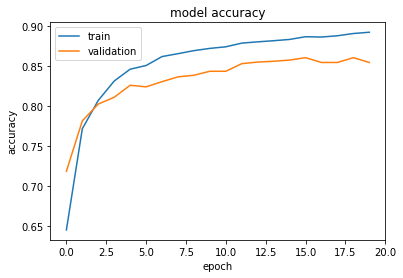

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim(-1, 20)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

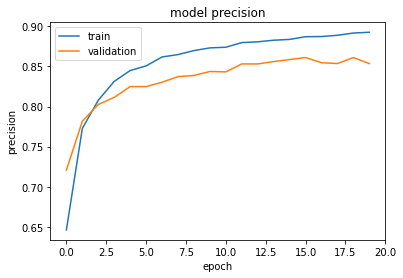

In [ ]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.xlim(-1, 20)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

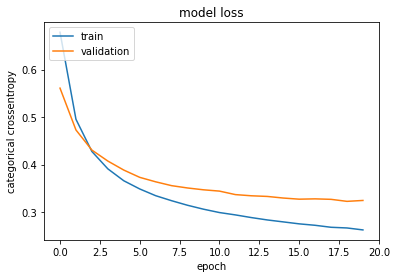

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical crossentropy')
plt.xlabel('epoch')
plt.xlim(-1, 20)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Saving the model

In this section, we save the trained model as an HDF5 file. It then predicts the classes of the test data using the predict() method and evaluates the performance of the model on the test data using the evaluate() method. The predicted labels and evaluation metrics are stored in the predictions and eval variables, respectively.


In [ ]:
from tensorflow.keras.models import load_model
model.save('AlcoholicDrinkDetectionFull') 

INFO:tensorflow:Assets written to: AlcoholicDrinkDetectionFull/assets


In [ ]:
test_labels = test_batches.classes

## Model Evaluation

In [ ]:
# Predict the test set using the trained model and print verbose output
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

29/29 [==============================] - 351s 12s/step


In [ ]:
# Evaluate the test set using the trained model
eval = model.evaluate(x=test_batches)

29/29 [==============================] - 13s 438ms/step - loss: 0.2888 - accuracy: 0.8789 - f1_m: 0.8825 - precision_m: 0.8825 - recall_m: 0.8825


In [ ]:
# Print the evaluation results
print('Test Results: ')
print('')
print('Categorical Corssentropy: ', np.around(eval[0], 3) )
print('Accuracy:                 ', np.around(eval[1], 3) )
print('F1 Measure:               ', np.around(eval[2], 3) )

Test Results: 

Categorical Corssentropy:  0.289
Accuracy:                  0.879
F1 Measure:                0.883


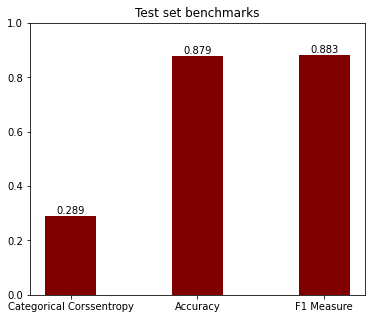

In [ ]:
# Create a dictionary of the evaluation metrics
data = {'Categorical Corssentropy': np.around(eval[0], 3), 'Accuracy':  np.around(eval[1], 3), 'F1 Measure':  np.around(eval[2], 3)} 

# Get the metrics and their values as separate lists
metrics = list(data.keys()) 
values = list(data.values()) 
  
# Create a bar chart to display the evaluation metrics
fig = plt.figure(figsize = (6, 5)) 
  
plt.bar(metrics, values, color ='maroon',  width = 0.4) 

# Add labels to the bars
for i in range(len(values)):
    plt.annotate(str(values[i]), xy=(metrics[i],values[i]), ha='center', va='bottom')
  
# Set the y-axis limits and add title to the chart
plt.ylim(0, 1)
plt.title("Test set benchmarks") 
plt.show() 

In [ ]:
# Define a function to plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # Add tick marks and labels to the plot
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Print the confusion matrix
    print(cm)

    # Add labels to the confusion matrix cells
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    # Set the plot labels and layout
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Get the true labels for the test set
test_labels = test_batches.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

# Get the class indices for the test set
test_batches.class_indices

{'alcoholic': 0, 'nonalcoholic': 1}

Confusion matrix, without normalization
[[400  50]
 [ 59 391]]


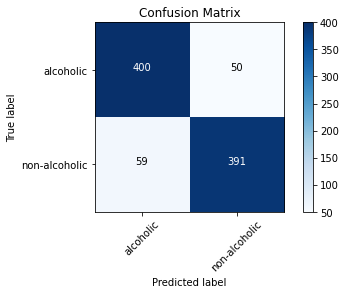

In [ ]:
# Set the labels for the confusion matrix plot
cm_plot_labels = ['alcoholic', 'non-alcoholic']

# Plot the confusion matrix
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Calculate the number of true/false positives/negatives
TP = cm[0, 0]
FP = cm[0, 1]
TN = cm[1, 1]
FN = cm[1, 0]

# Print the values 
print('True  Positive = ', TP)
print('Flase Positive = ', FP)
print('True  Negative = ', TN)
print('Flase Negative = ', FN)

True  Positive =  400
Flase Positive =  50
True  Negative =  391
Flase Negative =  59


In [ ]:
# Calculation of precision, recall, and F1-Score values
recall =    TP/(TP+FN)
percision = TP/(TP+FP) 
f1 = 2*(recall * percision) / (recall + percision)

print('Percision  = ', percision)
print('Recall     = ', recall)
print('F1 Measure = ', f1)

Percision  =  0.8888888888888888
Recall     =  0.8714596949891068
F1 Measure =  0.88008800880088


This section prints the classification report, which includes Precision, Recall, F1 Score, and Support for each class, as well as their weighted average.

In [ ]:
from sklearn.metrics import classification_report

y_pred = predictions
y_pred_bool = np.argmax(predictions, axis=1)
y_test = test_batches.classes

print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       450
           1       0.89      0.87      0.88       450

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900

